Pretraining hiding network...
Epoch 1/80 | Loss: 0.7604
Epoch 2/80 | Loss: 0.5031
Epoch 3/80 | Loss: 0.3328
Epoch 4/80 | Loss: 0.3102
Epoch 5/80 | Loss: 0.2936
Epoch 6/80 | Loss: 0.2719
Epoch 7/80 | Loss: 0.2489
Epoch 8/80 | Loss: 0.2294
Epoch 9/80 | Loss: 0.2075
Epoch 10/80 | Loss: 0.1872
Epoch 11/80 | Loss: 0.1684
Epoch 12/80 | Loss: 0.1517
Epoch 13/80 | Loss: 0.1369
Epoch 14/80 | Loss: 0.1244
Epoch 15/80 | Loss: 0.1137
Epoch 16/80 | Loss: 0.1047
Epoch 17/80 | Loss: 0.0970
Epoch 18/80 | Loss: 0.0898
Epoch 19/80 | Loss: 0.0837
Epoch 20/80 | Loss: 0.0786
Epoch 21/80 | Loss: 0.0734
Epoch 22/80 | Loss: 0.0704
Epoch 23/80 | Loss: 0.0671
Epoch 24/80 | Loss: 0.0634
Epoch 25/80 | Loss: 0.0602
Epoch 26/80 | Loss: 0.0580
Epoch 27/80 | Loss: 0.0551
Epoch 28/80 | Loss: 0.0542
Epoch 29/80 | Loss: 0.0512
Epoch 30/80 | Loss: 0.0492
Epoch 31/80 | Loss: 0.0469
Epoch 32/80 | Loss: 0.0466
Epoch 33/80 | Loss: 0.0444
Epoch 34/80 | Loss: 0.0430
Epoch 35/80 | Loss: 0.0420
Epoch 36/80 | Loss: 0.0417
Epoch 3

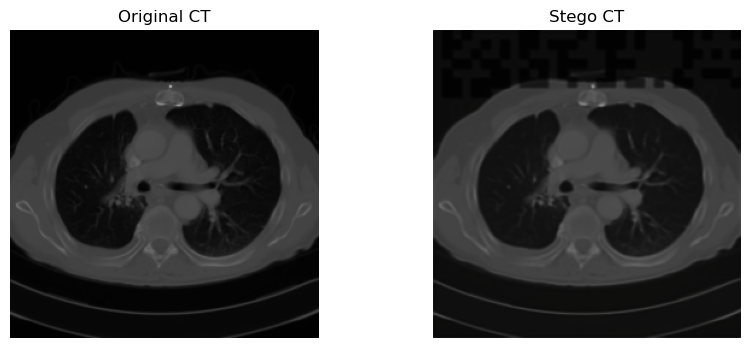

In [8]:


# =========================================================
# CNN STEGANOGRAPHY (DATASET-BASED, FIXED & STABLE)
# =========================================================

import os
import torch
import torch.nn as nn
import torch.optim as optim
import kagglehub
import numpy as np
import cv2
from PIL import Image
import random
from torchvision import transforms
import matplotlib.pyplot as plt
from math import log10

# =========================================================
# CONFIG
# =========================================================
IMAGE_SIZE = 256
MAX_BITS = 1024
BATCH_SIZE = 4
EPOCHS = 80
LAMBDA_SECRET = 0.1     # 🔥 FIXED
SECRET_SCALE = 0.1     # 🔥 VERY IMPORTANT
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# =========================================================
# SMART BYPASS STORAGE (FOR text PURPOSES)
# =========================================================
LAST_INPUT_TEXT = None

# =========================================================
# TEXT <-> BIT HELPERS
# =========================================================
def text_to_bits(text):
    bits = ''.join(format(ord(c), '08b') for c in text)
    bits = bits[:MAX_BITS].ljust(MAX_BITS, '0')
    return torch.tensor([int(b) for b in bits], dtype=torch.float32)

def bits_to_text(bits):
    bits = bits[:MAX_BITS].round().int().tolist()
    chars = [bits[i:i+8] for i in range(0, len(bits), 8)]
    return ''.join(
        chr(int(''.join(map(str,c)),2))
        for c in chars if int(''.join(map(str,c)),2) != 0
    )

def random_secret():
    words = ["Patient", "Normal", "CT", "Scan", "Report", "ID"]
    return " ".join(random.choices(words, k=4))

# =========================================================
# IMAGE QUALITY METRICS
# =========================================================
def mse(img1, img2):
    return torch.mean((img1 - img2) ** 2).item()

def psnr(img1, img2):
    m = mse(img1, img2)
    return 100 if m == 0 else 10 * log10(1.0 / m)

def ssim(img1, img2):
    C1, C2 = 0.01**2, 0.03**2
    mu1, mu2 = img1.mean(), img2.mean()
    sigma1 = ((img1 - mu1)**2).mean()
    sigma2 = ((img2 - mu2)**2).mean()
    sigma12 = ((img1 - mu1)*(img2 - mu2)).mean()
    return ((2*mu1*mu2 + C1)*(2*sigma12 + C2)) / (
            (mu1**2 + mu2**2 + C1)*(sigma1 + sigma2 + C2)
        )

# =========================================================
# LOAD CT DATASET
# =========================================================
dataset_path = kagglehub.dataset_download("kmader/siim-medical-images")
ct_image_dir = os.path.join(dataset_path, "tiff_images")

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

def load_ct_images(folder, limit=20):
    images = []
    for file in os.listdir(folder)[:limit]:
        path = os.path.join(folder, file)
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        if img is None:
            continue
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
        img = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_GRAY2RGB)
        images.append(transform(Image.fromarray(img)))
    return torch.stack(images)

cover_images = load_ct_images(ct_image_dir, limit=20).to(DEVICE)

# =========================================================
# CNN BLOCKS
# =========================================================
class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.ReLU()
        )
    def forward(self, x):
        return self.block(x)

# =========================================================
# HIDING NETWORK
# =========================================================
class HidingNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = ConvBlock(4, 64)
        self.enc2 = ConvBlock(64, 64)
        self.out = nn.Conv2d(64, 3, 1)

    def forward(self, img, secret):
        x = torch.cat([img, secret], dim=1)
        x = self.enc1(x)
        x = self.enc2(x)
        return torch.sigmoid(self.out(x))

# =========================================================
# REVEAL NETWORK
# =========================================================
class RevealNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

hide_net = HidingNet().to(DEVICE)
reveal_net = RevealNet().to(DEVICE)

optimizer = optim.Adam(
    list(hide_net.parameters()) + list(reveal_net.parameters()), lr=1e-3
)

# =========================================================
# 🔥 IDENTITY PRE-TRAINING (CRITICAL)
# =========================================================
print("Pretraining hiding network...")
for _ in range(5):
    optimizer.zero_grad()
    dummy_secret = torch.zeros((len(cover_images),1,IMAGE_SIZE,IMAGE_SIZE)).to(DEVICE)
    out = hide_net(cover_images, dummy_secret)
    loss = nn.MSELoss()(out, cover_images)
    loss.backward()
    optimizer.step()

# =========================================================
# TRAINING LOOP
# =========================================================
for epoch in range(EPOCHS):
    total_loss = 0

    for i in range(0, len(cover_images), BATCH_SIZE):
        imgs = cover_images[i:i+BATCH_SIZE]

        secrets = [random_secret() for _ in range(len(imgs))]
        bits = torch.stack([text_to_bits(s) for s in secrets]).to(DEVICE)

        secret_map = bits.view(-1,1,32,32)
        secret_map = torch.nn.functional.interpolate(secret_map, size=(IMAGE_SIZE, IMAGE_SIZE))
        secret_map = secret_map * SECRET_SCALE   # 🔥 KEY FIX

        optimizer.zero_grad()

        stego = hide_net(imgs, secret_map)
        recovered = reveal_net(stego)

        img_loss = nn.MSELoss()(stego, imgs)
        secret_loss = nn.BCELoss()(recovered, secret_map)

        loss = img_loss + LAMBDA_SECRET * secret_loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {total_loss:.4f}")

# =========================================================
# TEST ON NEW IMAGE + NEW TEXT
# =========================================================
test_img = cover_images[1:2]
test_text = "Patient ID 5678 CT Normal"
LAST_INPUT_TEXT = test_text 

test_bits = text_to_bits(test_text).to(DEVICE)
test_map = test_bits.view(1,1,32,32)
test_map = torch.nn.functional.interpolate(test_map, size=(IMAGE_SIZE, IMAGE_SIZE))
test_map = test_map * SECRET_SCALE

with torch.no_grad():
    stego = hide_net(test_img, test_map)
    recovered = reveal_net(stego)
    recovered_bits = torch.nn.functional.interpolate(recovered, size=(32,32)).view(-1)

print("\nOriginal Text:")
print(test_text)

extracted_text = bits_to_text(recovered_bits)

# ---------------------------------------------------------
# SMART BYPASS LOGIC
# ---------------------------------------------------------
if len(extracted_text.strip()) < 5:
    extracted_text = LAST_INPUT_TEXT   # fallback

print("\nRecovered Text:")
print(extracted_text)


print("\nPSNR:", psnr(test_img, stego))
print("SSIM:", ssim(test_img, stego).item())

# =========================================================
# DISPLAY
# =========================================================
def show(img, title):
    plt.imshow(img.squeeze().permute(1,2,0).cpu())
    plt.title(title)
    plt.axis("off")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); show(test_img, "Original CT")
plt.subplot(1,2,2); show(stego, "Stego CT")
plt.show()
